In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [23]:
train_df = pd.read_csv("data/train_df.csv")
test_df = pd.read_csv("data/test_df.csv")

In [24]:
train_df.head()

,user_id,item_id,rating,timestamp,movie_id,movie_title,release_date,imdb_url,Action,Adventure,...,zip_code,like_dislike,age_group,rating_date,rating_month,rating_day,release_year,release_month,release_day,movie_age
0,1,1,5,874965758,1,Toy Story (1995),1995-01-01,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,...,85711,Like,18-25,1997-09-22 22:02:38,9,Monday,1995.0,1.0,Sunday,995.0
1,1,2,3,876893171,2,GoldenEye (1995),1995-01-01,http://us.imdb.com/M/title-exact?GoldenEye%20(...,1,1,...,85711,Dislike,18-25,1997-10-15 05:26:11,10,Wednesday,1995.0,1.0,Sunday,1018.0
2,1,3,4,878542960,3,Four Rooms (1995),1995-01-01,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,...,85711,Like,18-25,1997-11-03 07:42:40,11,Monday,1995.0,1.0,Sunday,1037.0
3,1,4,3,876893119,4,Get Shorty (1995),1995-01-01,http://us.imdb.com/M/title-exact?Get%20Shorty%...,1,0,...,85711,Dislike,18-25,1997-10-15 05:25:19,10,Wednesday,1995.0,1.0,Sunday,1018.0
4,1,5,3,889751712,5,Copycat (1995),1995-01-01,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,...,85711,Dislike,18-25,1998-03-13 01:15:12,3,Friday,1995.0,1.0,Sunday,1167.0


In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90570 entries, 0 to 90569
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        90570 non-null  int64  
 1   item_id        90570 non-null  int64  
 2   rating         90570 non-null  int64  
 3   timestamp      90570 non-null  int64  
 4   movie_id       90570 non-null  int64  
 5   movie_title    90570 non-null  object 
 6   release_date   90562 non-null  object 
 7   imdb_url       90558 non-null  object 
 8   Action         90570 non-null  int64  
 9   Adventure      90570 non-null  int64  
 10  Animation      90570 non-null  int64  
 11  Children's     90570 non-null  int64  
 12  Comedy         90570 non-null  int64  
 13  Crime          90570 non-null  int64  
 14  Documentary    90570 non-null  int64  
 15  Drama          90570 non-null  int64  
 16  Fantasy        90570 non-null  int64  
 17  Film-Noir      90570 non-null  int64  
 18  Horror

## Exploratory Data Analysis

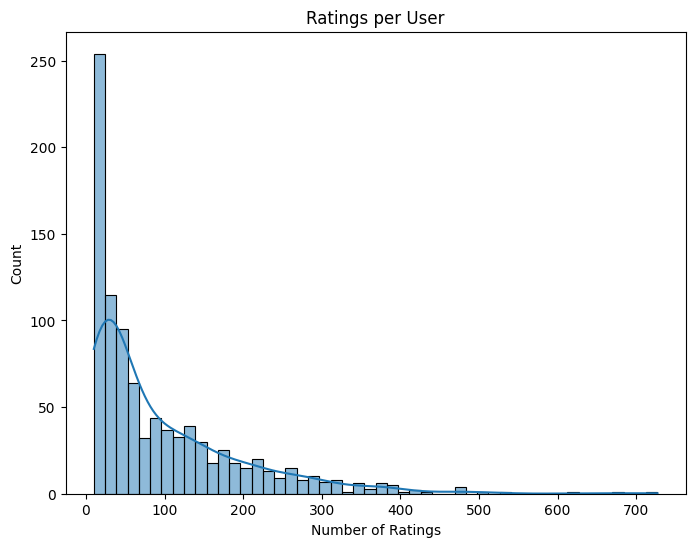

In [39]:
# histogram of ratings across users
user_ratings_count = train_df.groupby('user_id')['rating'].count()

plt.figure(figsize=(8, 6))
sns.histplot(user_ratings_count, bins=50, kde=True)
plt.title('Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()

We observe a long-tail distribution.

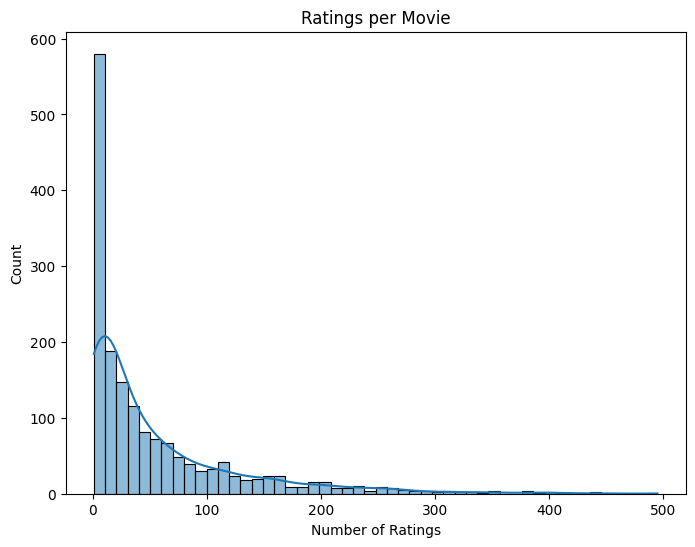

In [40]:
# histogram of ratings across movies
movie_ratings_count = train_df.groupby('movie_id')['rating'].count()

plt.figure(figsize=(8, 6))
sns.histplot(movie_ratings_count, bins=50, kde=True)
plt.title('Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()

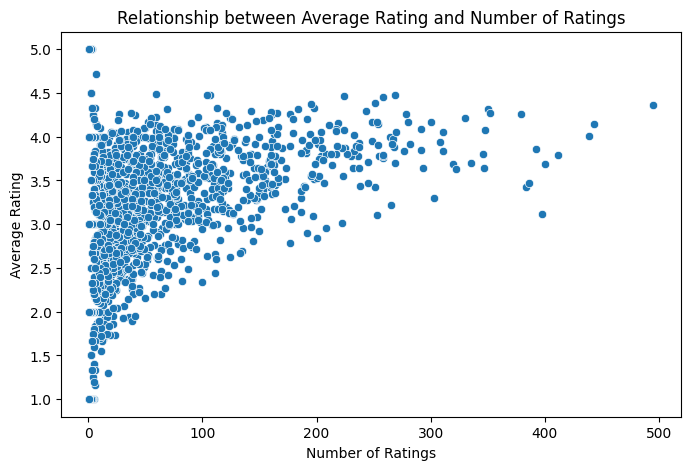

In [41]:
# relationship between average rating and number of ratings
movie_ratings_summary = train_df.groupby('movie_id').agg(
    ratings_count=('rating', 'count'),
    average_rating=('rating', 'mean')
).reset_index()

plt.figure(figsize=(8, 5))
sns.scatterplot(x='ratings_count', y='average_rating', data=movie_ratings_summary)
plt.title('Relationship between Average Rating and Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.show()

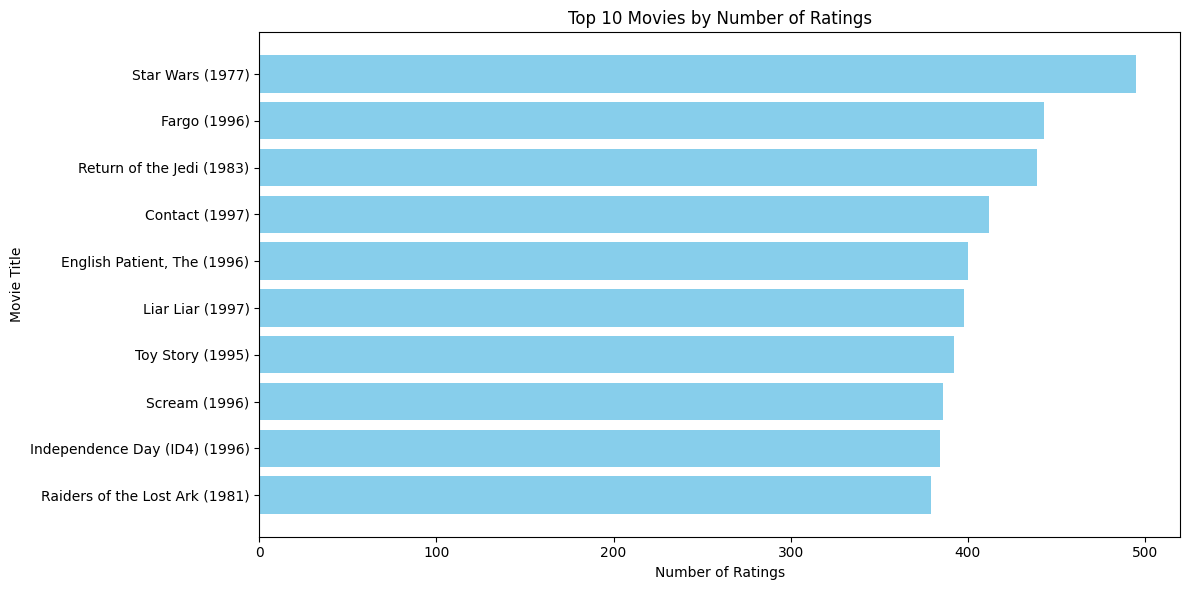

In [43]:
# plot top 10 most rated movies
movie_ratings_count = train_df['movie_id'].value_counts().reset_index()
movie_ratings_count.columns = ['movie_id', 'ratings_count']

movie_ratings_count = movie_ratings_count.sort_values(by='ratings_count', ascending=False)

num_top_movies_to_plot = 10 

top_movies = movie_ratings_count.head(num_top_movies_to_plot)

top_movies_titles = [train_df[train_df['movie_id'] == movie_id]['movie_title'].values[0] for movie_id in top_movies['movie_id']]

plt.figure(figsize=(12, 6))
plt.barh(top_movies_titles, top_movies['ratings_count'], color='skyblue')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.title(f'Top {num_top_movies_to_plot} Movies by Number of Ratings')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

## User-based Collaborative Filtering

In [26]:
from numpy.linalg import svd
from scipy.sparse.linalg import svds

In [27]:
# create user-movie rating matrix
user_movie_matrix = train_df.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
user_movie_matrix

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Latent Factors: 5, RMSE: 2.4749
Latent Factors: 10, RMSE: 2.3235
Latent Factors: 15, RMSE: 2.2446
Latent Factors: 20, RMSE: 2.1807
Latent Factors: 25, RMSE: 2.1268
Latent Factors: 30, RMSE: 2.0759
Latent Factors: 35, RMSE: 2.0281
Latent Factors: 40, RMSE: 1.9825
Latent Factors: 45, RMSE: 1.9394
Latent Factors: 50, RMSE: 1.8975


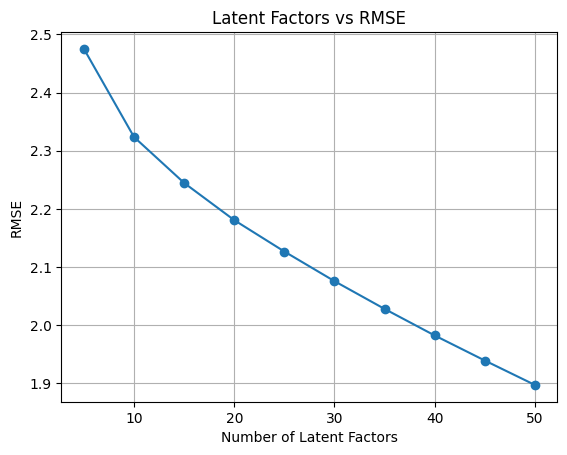

In [28]:
from sklearn.metrics import mean_squared_error
import numpy as np

# define latent factors range to test
latent_factors_range = range(5, 51, 5)  # from 5 to 50 latent factors in steps of 5
performance_results = {}  # to store performance scores

user_movie_matrix_np = user_movie_matrix.values

for num_latent_factors in latent_factors_range:
    u, sigma, vt = svds(user_movie_matrix_np, k=num_latent_factors)
    
    sigma_diag_matrix = np.diag(sigma) 
    predicted_ratings = np.dot(np.dot(u, sigma_diag_matrix), vt)
    
    # measure rmse
    mse = mean_squared_error(user_movie_matrix_np[user_movie_matrix_np.nonzero()].flatten(),
                             predicted_ratings[user_movie_matrix_np.nonzero()].flatten())
    rmse = np.sqrt(mse)
    
    performance_results[num_latent_factors] = rmse
    print(f"Latent Factors: {num_latent_factors}, RMSE: {rmse:.4f}")


plt.plot(list(performance_results.keys()), list(performance_results.values()), marker='o')
plt.xlabel('Number of Latent Factors')
plt.ylabel('RMSE')
plt.title('Latent Factors vs RMSE')
plt.grid()
plt.show()

In [29]:
# apply SVD
user_movie_matrix_np = user_movie_matrix.values # numpy array

num_latent_factors = 20 # iteration - try out different values (latent factors vs precision chart)
u, sigma, vt = svds(user_movie_matrix_np, k=num_latent_factors)

In [30]:
# convert sigma to diagonal matrix
sigma = np.diag(sigma)

# reconstruct the approximate matrix by multiplying u, s, and vt
reconstructed_matrix = np.dot(np.dot(u, sigma), vt)

predicted_ratings_df = pd.DataFrame(reconstructed_matrix, index=user_movie_matrix.index, columns=user_movie_matrix.columns)
predicted_ratings_df.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,4.288442,1.813650,1.258960,2.805239,0.747214,0.677089,4.142353,2.795650,3.102817,2.081667,...,-0.019291,0.005022,0.014531,0.009687,0.024531,-0.005180,-0.015541,-0.010361,0.036040,0.083441
2,1.950140,-0.039175,0.012099,0.632287,-0.178579,0.189589,1.677140,0.629339,2.227981,0.429815,...,-0.004925,-0.018992,-0.005476,-0.003651,0.002703,0.006384,0.019151,0.012767,-0.003177,-0.042445
3,-0.114805,-0.045030,0.199999,-0.148002,-0.109612,0.074084,-0.124621,-0.038621,-0.247918,0.096893,...,0.006595,-0.013233,0.015855,0.010570,-0.005899,0.012295,0.036886,0.024591,-0.000953,-0.002575
4,0.032093,-0.060496,0.009734,-0.035134,0.043915,-0.030536,0.208165,-0.200986,-0.050123,-0.015142,...,-0.001388,-0.006566,-0.000138,-0.000092,-0.002984,0.006221,0.018664,0.012442,0.005880,0.000385
5,2.941750,1.052037,0.328815,1.762116,0.197954,-0.099108,2.298877,1.115486,-0.621875,0.257435,...,-0.011875,0.004408,-0.030175,-0.020117,-0.022757,-0.000722,-0.002165,-0.001443,-0.008151,-0.017994


In [31]:
from sklearn.metrics.pairwise import cosine_similarity

k = 10  # number of closest users
max_recommendations = 6

# compute cosine similarity between users
user_similarity = cosine_similarity(predicted_ratings_df)
user_similarity_df = pd.DataFrame(user_similarity, index=predicted_ratings_df.index, columns=predicted_ratings_df.index)

# dictionary to store recommendations
recommendations = {}

for user_id in predicted_ratings_df.index:
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:k+1]
    
    user_rated_movies = train_df[train_df['user_id'] == user_id]['item_id'].values

    recommended_movies = []

    for similar_user_id in similar_users.index:
        similar_user_top_movies = predicted_ratings_df.loc[similar_user_id].sort_values(ascending=False)
        
        for movie_id, rating in similar_user_top_movies.items():
            if movie_id not in user_rated_movies and movie_id not in recommended_movies:
                recommended_movies.append(movie_id)
            if len(recommended_movies) >= max_recommendations:
                break
        if len(recommended_movies) >= max_recommendations:
            break

    recommendations[user_id] = recommended_movies


In [32]:
movie_id_to_title = train_df.set_index('item_id')['movie_title'].to_dict()

recommendation_titles = {}

for user_id, recommended_movie_ids in recommendations.items():
    recommended_movie_titles = [movie_id_to_title[movie_id] for movie_id in recommended_movie_ids]
    recommendation_titles[user_id] = recommended_movie_titles

# show recommendations for each user
for user_id, titles in list(recommendation_titles.items())[:10]:
    print(f"Recommendations for User {user_id}: {titles}")


Recommendations for User 1: ['Highlander (1986)', 'Trainspotting (1996)', 'Heathers (1989)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)', 'Batman (1989)', 'Real Genius (1985)']
Recommendations for User 2: ['Boot, Das (1981)', 'Star Wars (1977)', 'Amistad (1997)', 'Return of the Jedi (1983)', 'Wag the Dog (1997)', 'Grosse Pointe Blank (1997)']
Recommendations for User 3: ['Titanic (1997)', 'Conspiracy Theory (1997)', 'Apt Pupil (1998)', 'English Patient, The (1996)', 'Full Monty, The (1997)', 'As Good As It Gets (1997)']
Recommendations for User 4: ['L.A. Confidential (1997)', 'English Patient, The (1996)', 'Liar Liar (1997)', 'Titanic (1997)', 'Saint, The (1997)', 'Scream (1996)']
Recommendations for User 5: ['Brazil (1985)', 'Nightmare Before Christmas, The (1993)', 'Toy Story (1995)', 'Twelve Monkeys (1995)', 'Raising Arizona (1987)', 'Groundhog Day (1993)']
Recommendations for User 6: ['Rear Window (1954)', "Singin' in the Rain (1952)", 'Clockwork O

In [33]:
# top 10 similar users for each user
top_similar_users = {}

for user_id in user_similarity_df.index:
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).iloc[1:k+1].index.tolist()
    top_similar_users[user_id] = similar_users

for user_id, similar_users in list(top_similar_users.items())[:10]:
    print(f"Top 10 similar users for User {user_id}: {similar_users}")


Top 10 similar users for User 1: [268, 62, 889, 916, 806, 763, 64, 198, 868, 514]
Top 10 similar users for User 2: [931, 701, 460, 463, 735, 413, 390, 905, 104, 768]
Top 10 similar users for User 3: [863, 842, 801, 519, 695, 587, 752, 724, 784, 489]
Top 10 similar users for User 4: [61, 143, 510, 628, 35, 772, 529, 812, 351, 509]
Top 10 similar users for User 5: [795, 660, 407, 738, 307, 922, 497, 648, 22, 102]
Top 10 similar users for User 6: [409, 10, 321, 840, 666, 189, 452, 747, 383, 535]
Top 10 similar users for User 7: [650, 406, 846, 766, 194, 313, 561, 234, 843, 60]
Top 10 similar users for User 8: [600, 746, 197, 826, 37, 466, 619, 757, 638, 425]
Top 10 similar users for User 9: [430, 68, 723, 419, 785, 680, 27, 395, 576, 560]
Top 10 similar users for User 10: [6, 747, 666, 664, 535, 527, 452, 908, 409, 573]


In [34]:
def calculate_correct_predictions(recommendations, test_df, k_values):
    relevant_items = test_df.groupby('user_id')['item_id'].apply(set).to_dict()
    
    percentage_correct_predictions = {}
    mean_percentage_correct_predictions = {}

    for k in k_values:
        correct_predictions_count = []
        
        for user_id, recommended_movies in recommendations.items():
            recommended_movies_k = recommended_movies[:k]

            true_positives = len(set(recommended_movies_k) & relevant_items.get(user_id, set()))
            correct_predictions_count.append(true_positives / k if k > 0 else 0)
        
        mean_percentage_correct_predictions[k] = np.mean(correct_predictions_count)
        percentage_correct_predictions[k] = correct_predictions_count

    return percentage_correct_predictions, mean_percentage_correct_predictions

# set different k values
k_values = [1, 2, 3, 4, 5, 6]

percentage_correct_predictions, mean_percentage_correct_predictions = calculate_correct_predictions(recommendations, test_df, k_values)
for k in k_values:
    print(f"Mean Percentage of Correct Predictions for k={k}: {mean_percentage_correct_predictions[k]:.2%}")


Mean Percentage of Correct Predictions for k=1: 42.42%
Mean Percentage of Correct Predictions for k=2: 36.16%
Mean Percentage of Correct Predictions for k=3: 33.76%
Mean Percentage of Correct Predictions for k=4: 31.26%
Mean Percentage of Correct Predictions for k=5: 29.20%
Mean Percentage of Correct Predictions for k=6: 27.36%


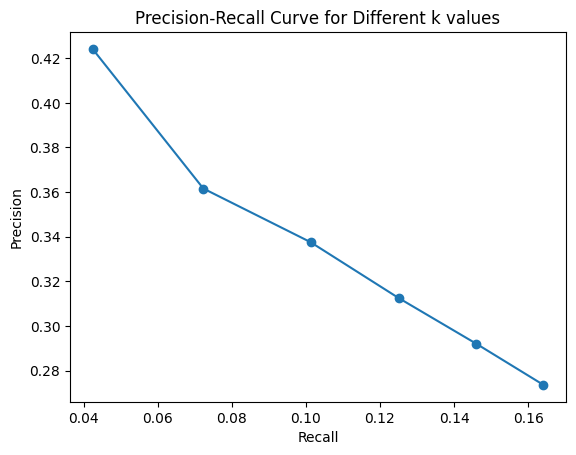

In [37]:
def calculate_precision_recall(recommendations, test_df, K):
    # Convert test_df to a set of relevant items for each user
    relevant_items = test_df.groupby('user_id')['item_id'].apply(set).to_dict()
    
    precision_list = []
    recall_list = []

    for user_id, recommended_movies in recommendations.items():
        # Only consider the top K recommendations
        recommended_movies_k = recommended_movies[:K]

        true_positives = len(set(recommended_movies_k) & relevant_items.get(user_id, set()))
        precision = true_positives / len(recommended_movies_k) if len(recommended_movies_k) > 0 else 0
        recall = true_positives / len(relevant_items.get(user_id, set())) if len(relevant_items.get(user_id, set())) > 0 else 0

        precision_list.append(precision)
        recall_list.append(recall)

    mean_precision = np.mean(precision_list)
    mean_recall = np.mean(recall_list)

    return mean_precision, mean_recall

precision_values = []
recall_values = []

for k in range(1, 7):
    precision_k, recall_k = calculate_precision_recall(recommendations, test_df, k)
    precision_values.append(precision_k)
    recall_values.append(recall_k)

plt.plot(recall_values, precision_values, marker='o')
plt.title("Precision-Recall Curve for Different k values")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

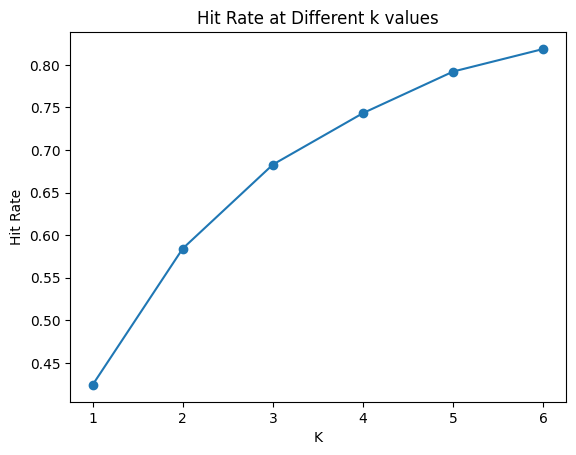

In [38]:
def calculate_hit_rate(recommendations, test_df, K):
    relevant_items = test_df.groupby('user_id')['item_id'].apply(set).to_dict()
    hits = 0
    for user_id, recommended_movies in recommendations.items():
        if len(set(recommended_movies[:K]) & relevant_items.get(user_id, set())) > 0:
            hits += 1
    return hits / len(recommendations)

k_values = range(1, 7)
hit_rates = [calculate_hit_rate(recommendations, test_df, k) for k in k_values]

plt.plot(k_values, hit_rates, marker='o')
plt.title("Hit Rate at Different k values")
plt.xlabel("K")
plt.ylabel("Hit Rate")
plt.show()